# Testing Stock Market Prices for Overreaction

## Introduction

## De Bondt and Thaler (1985)

In the seminal paper, "Does the stock market overreact?" De Bondt and Thaler (1985) discover significant evidence of weak-form market inefficiencies. 

## Objective

- Test for the overreaction hypothesis in financial markets based on 
  [De Bondt and Thaler (1985), Does the Stock Market Overreact?,
  Journal of Finance](http://onlinelibrary.wiley.com/doi/10.1111/j.1540-6261.1985.tb05004.x/full).
- Get similar results to Figure 3 in the paper.

## Motivation

- "Research in experimental psychology has suggested that, in violation of Bayes' rule, most people tend to "overreact" to unexpected and dramatic news events." ~ De Bondt and Thaler (1985)
- Does such behavior matter at the market level?

## Key Steps

The beauty in De Bondt and Thaler's empirical test of overreaction hypothesis is its simplicity. Specifically, what DeBondt and Thaler do is calculate portfolio returns for some formation period – i.e. previous 36-month performance – and then see how that particular portfolio performs in an evaluation period – i.e. subsequent 36-month performance. To test the overreaction hypothesis, De Bondt and Thaler form loser and winner portfolios composed of the 30 worst-performing and 30 best-performing stocks, respectively, over the formation period. They then follow these portfolios for the subsequent 36 months and evaluate and compare their performance. The key steps are summarized below:

1. Identify portfolio formation dates.
2. Identify winner and loser portfolios by ranking securities by past returns.
3. Track and calculate the holding period returns for each portfolio.

## Setup

### Importing packages

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy import stats
import os

### Import/Wrangle and Cleaning Data

In [2]:
df_crsp = pd.read_csv('monthly.csv', na_values=['C'], parse_dates=['DATE']) 
#When you see C, register as NA,parse_dates turns column 'DATE' to datetime

# The output from WRDS returns a mixed of small and large cap column names. Let's standardize everything in small caps.
cols = df_crsp.columns
print(cols)
print(type(cols))

# List comprehension [expression for variable in iterable]
df_crsp.columns = [c.lower() for c in cols] 

Index(['PERMNO', 'DATE', 'PRC', 'RET', 'SHROUT', 'VWRETD', 'EWRETD'], dtype='object')
<class 'pandas.core.indexes.base.Index'>


In [3]:
# Sanitize dataset

# Drop observations with missing returns
df_crsp = df_crsp[df_crsp.ret.notnull()]

# Take the absolute value of the price
df_crsp['prc'] = np.abs(df_crsp['prc'])

# Set the index (to select easily on date)
df_crsp = df_crsp.set_index('date')
df_crsp = df_crsp.sort_index()

# Compute continuously compounded returns (i.e. log returns).
df_crsp['lret'] = np.log(1 + df_crsp['ret']) #log returns
df_crsp['lvwretd'] = np.log(1 + df_crsp['vwretd']) #value weighted
df_crsp['lewretd'] = np.log(1 + df_crsp['ewretd']) #equally weighted

# Compute the market cap
df_crsp['size'] = df_crsp['shrout'] * df_crsp['prc'] #shares outstanding * price

df_crsp.head()

,permno,prc,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size
date,,,,,,,,,,
1926-06-30,25566,39.50,0.083784,95.0,0.053664,0.050487,0.080459,0.052274,0.049254,3752.5
1926-06-30,15587,45.75,0.066281,240.0,0.053664,0.050487,0.064177,0.052274,0.049254,10980.0
1926-06-30,12917,18.00,0.058824,1360.0,0.053664,0.050487,0.057159,0.052274,0.049254,24480.0
1926-06-30,10858,64.50,-0.042672,770.0,0.053664,0.050487,-0.043609,0.052274,0.049254,49665.0
1926-06-30,11594,47.00,0.002667,300.0,0.053664,0.050487,0.002663,0.052274,0.049254,14100.0


### Defining Parameters

In [4]:
# Parameters
form_period = 36 # 36 Formation period, in month
start_date = '1933-01-01' 
end_date = '2000-01-01' 

# Get the dates of portfolio formation.
# The frequency tells how far apart to put the dates.
# 'M' stand for month, 'MS' is for month start, to make sure we 
# have first day of the month. It needs to be a string, so we convert
# our numbers to string. 
dates = pd.date_range(start=start_date, end=end_date, freq=str(np.int(form_period)) + 'M')

date = dates[0]
beg_dt = date - pd.offsets.MonthEnd(1) * form_period

### Defining Functions

In [5]:
#defining function to compute performace portfolios

def compute_performance_portfolios(date, df, form_period, n_stocks, benchmark):
    beg_dt = date - pd.offsets.MonthBegin(1) * form_period

    # Select obs for the formation period
    crsp_t = df[beg_dt:date].copy()
    
    # We only want to keep stocks that are there during the full formation window
    crsp_t['N'] = crsp_t.groupby(['permno'])['permno'].transform('count')
    # Filter on number of observations. We only keep sotcks for which we have returns
    # over the full observation period.
    crsp_t = crsp_t[crsp_t['N'] >= form_period]
    
    # Now for each stock we want to compute the full period return. Easy with log returns, just sum up!
    stock_ret = crsp_t.groupby('permno')[['lret', 'lvwretd', 'lewretd']].sum()
    
    # Next compute excess returns based on the chosen index.
    # Note that since the benchmark is the same for all stocks, we could use
    # actual returns for ranking purposes.
    stock_ret['lexret'] = stock_ret['lret'] - stock_ret['l' + benchmark]
    
    # Now rankings.
    stock_ret['rank_asc'] = stock_ret['lexret'].rank() # (1 = worst return)
    stock_ret['rank_inv'] = stock_ret['lexret'].rank(ascending=False) # (1= best return)
    
    # Assign stock to top or bottom portfolio
    top_portfolio = stock_ret[stock_ret.rank_inv <= n_stocks].reset_index()[['permno', 'lexret']]
    bottom_portfolio = stock_ret[stock_ret.rank_asc <= n_stocks].reset_index()[['permno', 'lexret']]
    
    return (bottom_portfolio, top_portfolio)

In [6]:
#Defining function to compute holding period returns

def compute_holding_returns(date, portfolio, df, benchmark, weighting, hold_per):
    portfolio = portfolio.copy()
    end_dt = date + pd.offsets.MonthBegin(1) * hold_per
    # Select obs for the formation period
    crsp_t2 = df[date:end_dt].copy()
    # Merge with stocks in portfolios, to keep only those stocks
    crsp_t2 = pd.merge(crsp_t2.reset_index(), portfolio, on=['permno'])
    crsp_t2
    

    # Get the dates in the dataset.
    pairs_t2 = [{'date': d, 'permno': p} for d in crsp_t2['date'].unique() for p in portfolio['permno'].unique()]
    pairs_t2 = pd.DataFrame(pairs_t2)
    pairs_t2
    crsp_t2 = pd.merge(crsp_t2, pairs_t2, how='outer', on=['permno', 'date'])
    ret_cols = ['ret', 'vwretd', 'ewretd', 'lvwretd','lewretd', 'lret', 'lexret']
    crsp_t2[ret_cols] = crsp_t2[ret_cols].fillna(0.0)
    
    # Now we want the return up to each point in time
    crsp_t2['lcumret'] = crsp_t2.groupby('permno')['lret'].cumsum()
    crsp_t2['lcum' + benchmark] = crsp_t2.groupby('permno')['l' + benchmark].cumsum()

    # At each point in time, the return of the portfolio will be the 
    # cumulative return of each component weighted by the initial weight.
    # Note that here we need the simple return average, not log return.
    crsp_t2['cumret'] = np.exp(crsp_t2['lcumret']) - 1
    crsp_t2['cum' + benchmark] = np.exp(crsp_t2['lcum' + benchmark]) - 1

    # Add weights, equal weighted is easy.
    portfolio['ew'] = 1 / len(portfolio)

    # For value-weighted, need to get size as of formation date.
    portfolio['date'] = date
    weights = pd.merge_asof(portfolio, df_crsp[['permno', 'size']],
                            by='permno',
                            left_on='date',
                            right_index=True)
    weights['vw'] = weights['size'] / weights['size'].sum()

    del weights['lexret']
    del weights['date']
    del weights['size']
    
    # Now merge back with returns
    crsp_t2 = pd.merge(crsp_t2, weights, on='permno')
    
    # Now compute the weighted cumulative return
    crsp_t2['wcumret'] = crsp_t2[weighting] * crsp_t2['cumret']
    crsp_t2['wcum' + benchmark] = crsp_t2[weighting] * crsp_t2['cum' + benchmark]

    portfolio_ret = crsp_t2.groupby(['date'])[['wcumret', 'wcum' + benchmark]].sum()
    
    # Count the months
    portfolio_ret = portfolio_ret.reset_index()
    portfolio_ret['months'] = portfolio_ret.index.values + 1
    
    portfolio_ret['exret'] = portfolio_ret['wcumret'] - portfolio_ret['wcum' + benchmark]
    
    return portfolio_ret

## What are some of the exogenous events that may drive overreaction? How may behavioural finance theories explain the recent ebb and flow in the global financial markets?

Overreaction results from emotional responses of greed or fear from investors to new information about the market, resulting in the security being overbought or oversold. 

One example of an exogenous event that may have driven overreaction in the market is the current COVID-19 pandemic. Due to the travel restrictions placed by various central governments, there was a crash in the stocks of many companies whose large portion of revenues come from travellers. 

One example would be Disney, which although has many diverse revenue streams, is also a major travel destination for its themeparks and cruises. Disney's stock price fell by close to 58% from the start of the year to its lowest point in March. However, despite the pandemic still continuing its spread and even worsening in many developed cities, and there being travel restrictions still in place for many countries, the price of Disney's stock has recovered by 50% in the last five months as of 18 Aug 2020. 

This could be a sign of correlated-biases being present in the market, where 



## Are the results sensitive to alternative definitions of winners/losers? Alternative benchmark? Alternative weightings? Alternative formation month (e.g., June)? Alternative formation period?

### Creating a new function to run everything together so we can scale it with different iterations

This function has the additional variables of start_date and the corresponding variable dates to accomodate for defining alternative formation dates.
Another additional variable is graph_title which is included just for easier labeling of future graphs.

In [7]:
#Include function variables of start_date and graph_title
def differentportfolios(date, start_date, df,form_period,n_stocks,benchmark, weighting, hold_per, graph_title):
    #Include date range to dictate the start_date of portfolio formation for future alteration
    dates = pd.date_range(start=start_date, end=end_date, freq=str(np.int(form_period)) + 'M')
    portfolios = {}
    for date in dates:
        portfolios[date] = compute_performance_portfolios(date, df_crsp,form_period,n_stocks,benchmark)
    portfolio = portfolios[date][0] # Bottom portfolio.
    bottom_portfolio_ret = []
    top_portfolio_ret = []
    
    for date in dates:
        bottom_portfolio_ret.append(compute_holding_returns(date, portfolios[date][0], df_crsp, benchmark, weighting,hold_per))
        top_portfolio_ret.append(compute_holding_returns(date, portfolios[date][1], df_crsp, benchmark, weighting,hold_per))
    bottom_portfolio_ret = pd.concat(bottom_portfolio_ret)
    top_portfolio_ret = pd.concat(top_portfolio_ret)    
    ax = bottom_portfolio_ret.groupby('months')['exret'].mean().plot(label='Past losers')
    top_portfolio_ret.groupby('months')['exret'].mean().plot(ax=ax, label='Past winners')
    ax.legend()
    ax.set_title(label = graph_title)
    ax.axhline(y=0,  color='black', alpha=0.5, linestyle=':')
    ax.axvline(x=12, color='black', alpha=0.5, linestyle='-')
    ax.axvline(x=24, color='black', alpha=0.5, linestyle='-')
    plt.show()
    
    tset, pval = stats.ttest_ind(top_portfolio_ret[top_portfolio_ret['months']==hold_per].set_index('date')['exret'],
                             bottom_portfolio_ret[top_portfolio_ret['months']==hold_per].set_index('date')['exret'])
    print('Mean Excess Return for Top Performing Funds ' + str(top_portfolio_ret[top_portfolio_ret['months']==hold_per].set_index('date')['exret'].mean()))
    print('Mean Excess Return for Bottom Performing Funds ' + str(bottom_portfolio_ret[top_portfolio_ret['months']==hold_per].set_index('date')['exret'].mean()))
    print('Mean Difference Bottom Minus Top in Excess Return ' + 
          str(bottom_portfolio_ret[top_portfolio_ret['months']==hold_per].set_index('date')['exret'].mean() -                                                        
              top_portfolio_ret[top_portfolio_ret['months']==hold_per].set_index('date')['exret'].mean()))
    print('P-values ' + str(pval))
    if pval < 0.05:    # alpha value is 0.05 or 5%
        print(" we are rejecting null hypothesis")
    else:
        print("we are accepting null hypothesis")

### Running iterations with different alternatives to show capabilities of the function

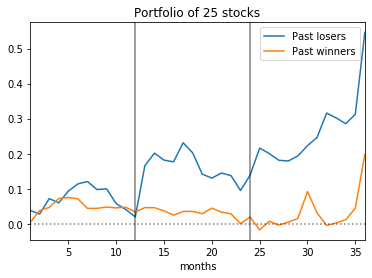

Mean Excess Return for Top Performing Funds 0.19854365137688368
Mean Excess Return for Bottom Performing Funds 0.5465004786033077
Mean Difference Bottom Minus Top in Excess Return 0.34795682722642407
P-values 0.35216770363560335
we are accepting null hypothesis


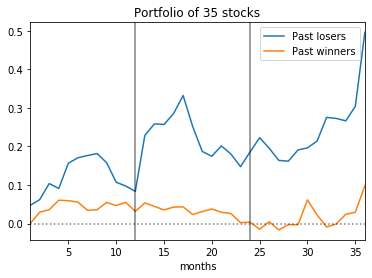

Mean Excess Return for Top Performing Funds 0.09816565316053763
Mean Excess Return for Bottom Performing Funds 0.4963417883224802
Mean Difference Bottom Minus Top in Excess Return 0.3981761351619426
P-values 0.24219642894820548
we are accepting null hypothesis


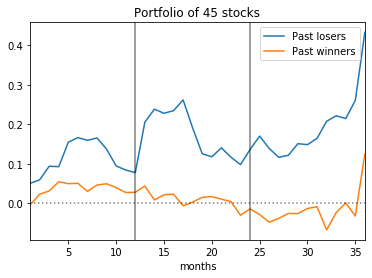

Mean Excess Return for Top Performing Funds 0.12548141223836384
Mean Excess Return for Bottom Performing Funds 0.43331387092648765
Mean Difference Bottom Minus Top in Excess Return 0.3078324586881238
P-values 0.28310215654095144
we are accepting null hypothesis


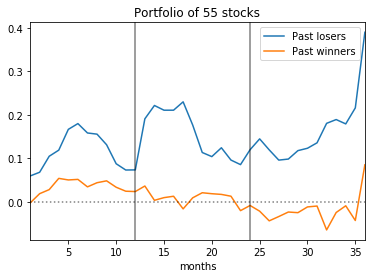

Mean Excess Return for Top Performing Funds 0.08515794528803253
Mean Excess Return for Bottom Performing Funds 0.39023951974654464
Mean Difference Bottom Minus Top in Excess Return 0.30508157445851214
P-values 0.2618623853521042
we are accepting null hypothesis


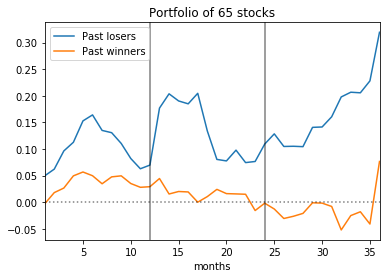

Mean Excess Return for Top Performing Funds 0.07653278488924892
Mean Excess Return for Bottom Performing Funds 0.3194902514145715
Mean Difference Bottom Minus Top in Excess Return 0.24295746652532257
P-values 0.3284162742999608
we are accepting null hypothesis


In [8]:
# Testing with alternative nstock levels as alternative definitions of winners and losers
nlist = [25,35,45,55,65]
for n in nlist:
    differentportfolios(date,start_date,df=df_crsp,form_period=36,n_stocks=n,benchmark='vwretd',weighting='vw',hold_per=36, graph_title = "Portfolio of " + str(n) + " stocks")

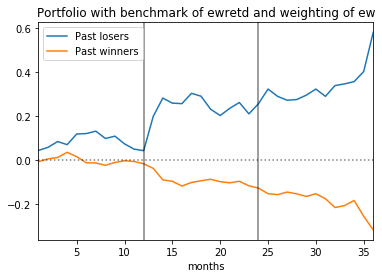

Mean Excess Return for Top Performing Funds -0.31728871854360063
Mean Excess Return for Bottom Performing Funds 0.5816294796980345
Mean Difference Bottom Minus Top in Excess Return 0.8989181982416351
P-values 0.036319034487855305
 we are rejecting null hypothesis


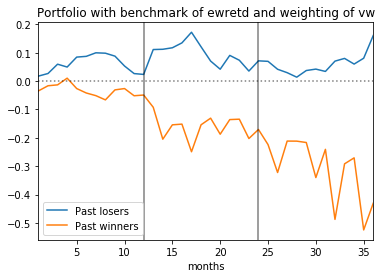

Mean Excess Return for Top Performing Funds -0.4306119235934824
Mean Excess Return for Bottom Performing Funds 0.16071567411208007
Mean Difference Bottom Minus Top in Excess Return 0.5913275977055624
P-values 0.119085911588728
we are accepting null hypothesis


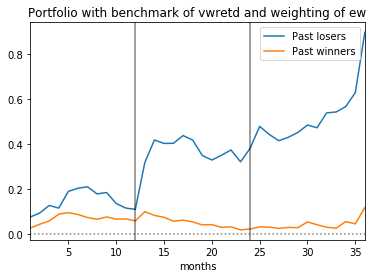

Mean Excess Return for Top Performing Funds 0.11800298630686361
Mean Excess Return for Bottom Performing Funds 0.8987878508414477
Mean Difference Bottom Minus Top in Excess Return 0.7807848645345842
P-values 0.11036693993788357
we are accepting null hypothesis


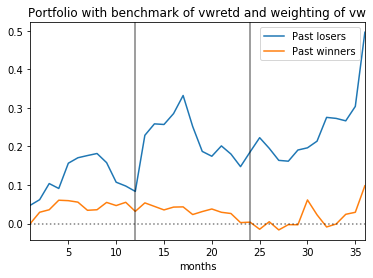

Mean Excess Return for Top Performing Funds 0.09816565316053763
Mean Excess Return for Bottom Performing Funds 0.4963417883224802
Mean Difference Bottom Minus Top in Excess Return 0.3981761351619426
P-values 0.24219642894820548
we are accepting null hypothesis


In [9]:
# Testing with alternative benchmarks and weightings
benchmarks = ["ewretd", "vwretd"]
weightings = ["ew", "vw"]
for b in benchmarks:
    for w in weightings:
        differentportfolios(date,start_date,df=df_crsp,form_period=36,n_stocks=35,benchmark=b,weighting=w,hold_per=36, graph_title = "Portfolio with benchmark of " + str(b) + " and weighting of " + str(w))

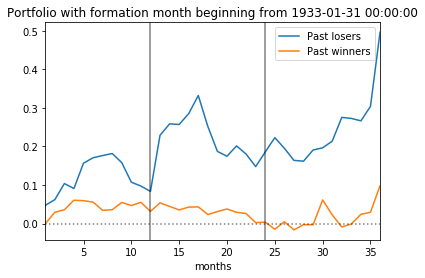

Mean Excess Return for Top Performing Funds 0.09816565316053763
Mean Excess Return for Bottom Performing Funds 0.4963417883224802
Mean Difference Bottom Minus Top in Excess Return 0.3981761351619426
P-values 0.24219642894820548
we are accepting null hypothesis


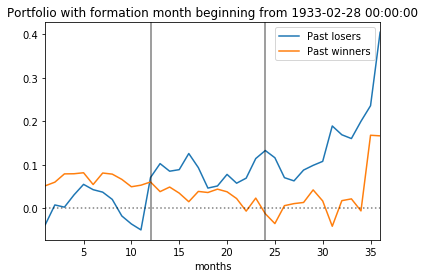

Mean Excess Return for Top Performing Funds 0.1665181061330576
Mean Excess Return for Bottom Performing Funds 0.40426854333546974
Mean Difference Bottom Minus Top in Excess Return 0.23775043720241215
P-values 0.4568420727229867
we are accepting null hypothesis


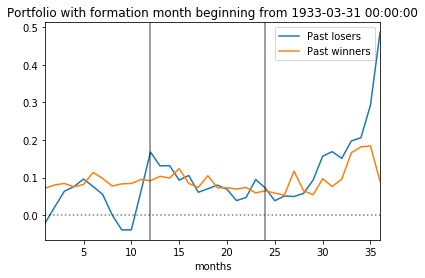

Mean Excess Return for Top Performing Funds 0.08961102364602809
Mean Excess Return for Bottom Performing Funds 0.4869704517836257
Mean Difference Bottom Minus Top in Excess Return 0.3973594281375976
P-values 0.17977692067997858
we are accepting null hypothesis


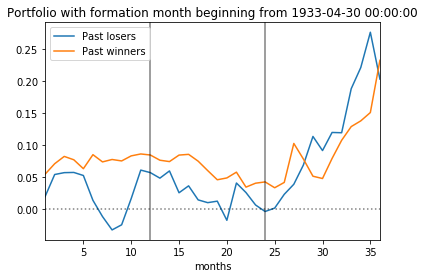

Mean Excess Return for Top Performing Funds 0.23225481921615787
Mean Excess Return for Bottom Performing Funds 0.20291505942479143
Mean Difference Bottom Minus Top in Excess Return -0.029339759791366438
P-values 0.9283193958614075
we are accepting null hypothesis


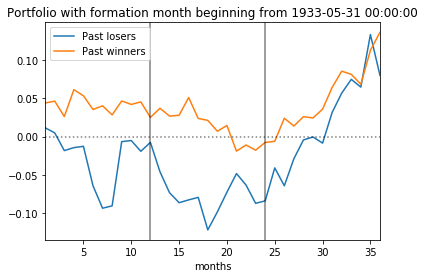

Mean Excess Return for Top Performing Funds 0.13603404691390697
Mean Excess Return for Bottom Performing Funds 0.07973320466366324
Mean Difference Bottom Minus Top in Excess Return -0.05630084225024373
P-values 0.8156766716615043
we are accepting null hypothesis


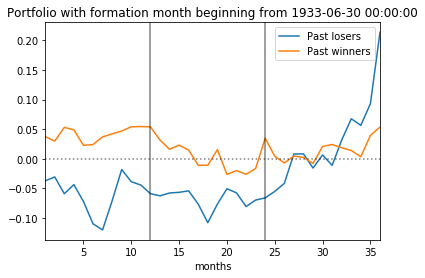

Mean Excess Return for Top Performing Funds 0.05342027755651829
Mean Excess Return for Bottom Performing Funds 0.21379555079964924
Mean Difference Bottom Minus Top in Excess Return 0.16037527324313094
P-values 0.49748183081413266
we are accepting null hypothesis


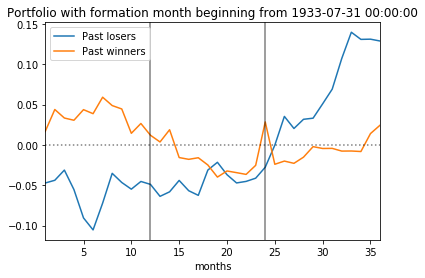

Mean Excess Return for Top Performing Funds 0.02441645977105859
Mean Excess Return for Bottom Performing Funds 0.12884578828771087
Mean Difference Bottom Minus Top in Excess Return 0.10442932851665228
P-values 0.6988987740969796
we are accepting null hypothesis


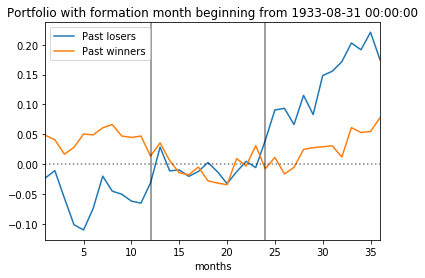

Mean Excess Return for Top Performing Funds 0.07801485100281648
Mean Excess Return for Bottom Performing Funds 0.17440219948067986
Mean Difference Bottom Minus Top in Excess Return 0.09638734847786339
P-values 0.7077316414416397
we are accepting null hypothesis


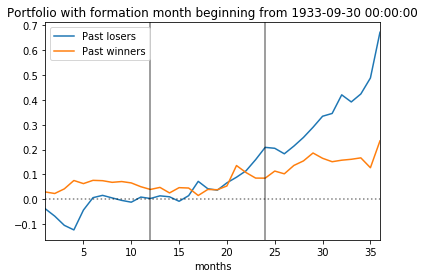

Mean Excess Return for Top Performing Funds 0.23489848777638536
Mean Excess Return for Bottom Performing Funds 0.6721478258855674
Mean Difference Bottom Minus Top in Excess Return 0.4372493381091821
P-values 0.3436111704097431
we are accepting null hypothesis


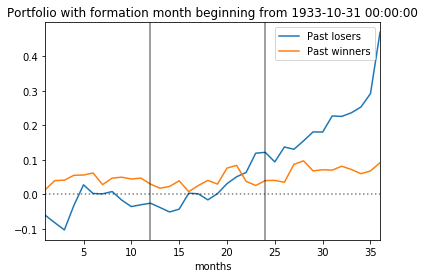

Mean Excess Return for Top Performing Funds 0.09177893505519918
Mean Excess Return for Bottom Performing Funds 0.4703349920806887
Mean Difference Bottom Minus Top in Excess Return 0.3785560570254895
P-values 0.39499159593053257
we are accepting null hypothesis


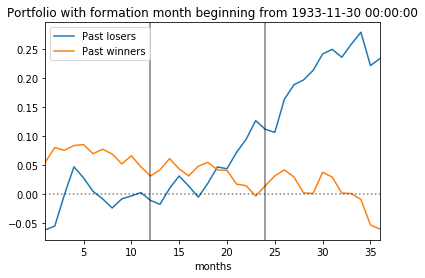

Mean Excess Return for Top Performing Funds -0.060079789886426
Mean Excess Return for Bottom Performing Funds 0.2336692008884284
Mean Difference Bottom Minus Top in Excess Return 0.2937489907748544
P-values 0.3027459459075084
we are accepting null hypothesis


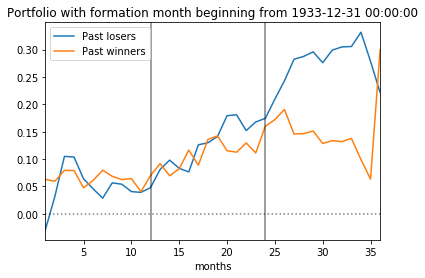

Mean Excess Return for Top Performing Funds 0.29979313301110344
Mean Excess Return for Bottom Performing Funds 0.22160269299891314
Mean Difference Bottom Minus Top in Excess Return -0.0781904400121903
P-values 0.8214387653405937
we are accepting null hypothesis


In [10]:
# Testing with alternative formation month e.g. June

#Generate a list of alternative formation months
formation_months = pd.date_range(start='1933-01-01', end='1934-01-01', freq='M')

for m in formation_months:
    differentportfolios(date, start_date = m, df = df_crsp, form_period = 36, n_stocks = 35, benchmark = 'vwretd', weighting = 'vw',hold_per = 36, graph_title = "Portfolio with formation month beginning from " + str(m))

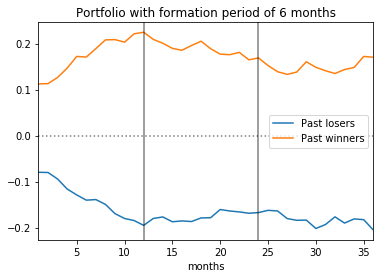

Mean Excess Return for Top Performing Funds 0.1703578419362625
Mean Excess Return for Bottom Performing Funds -0.20519192048306642
Mean Difference Bottom Minus Top in Excess Return -0.3755497624193289
P-values 6.072913514685432e-06
 we are rejecting null hypothesis


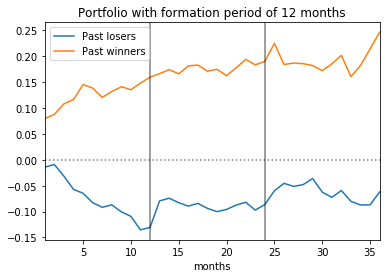

Mean Excess Return for Top Performing Funds 0.24658734429178356
Mean Excess Return for Bottom Performing Funds -0.06210945628952974
Mean Difference Bottom Minus Top in Excess Return -0.3086968005813133
P-values 0.12558941005824242
we are accepting null hypothesis


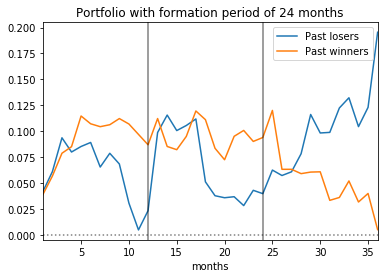

Mean Excess Return for Top Performing Funds 0.005000963753209575
Mean Excess Return for Bottom Performing Funds 0.19551581867995282
Mean Difference Bottom Minus Top in Excess Return 0.19051485492674325
P-values 0.3252461266391701
we are accepting null hypothesis


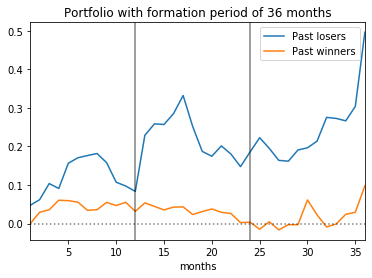

Mean Excess Return for Top Performing Funds 0.09816565316053763
Mean Excess Return for Bottom Performing Funds 0.4963417883224802
Mean Difference Bottom Minus Top in Excess Return 0.3981761351619426
P-values 0.24219642894820548
we are accepting null hypothesis


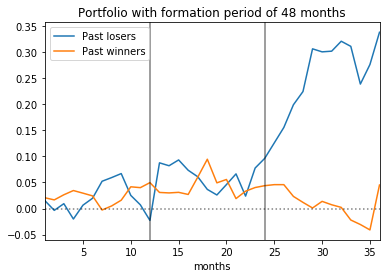

Mean Excess Return for Top Performing Funds 0.04503261756512691
Mean Excess Return for Bottom Performing Funds 0.3376644023821556
Mean Difference Bottom Minus Top in Excess Return 0.29263178481702873
P-values 0.32471778738693347
we are accepting null hypothesis


In [11]:
# Testing with alternative portfolio formation periods
formlist = [6,12,24,36,48]
for f in formlist:
    differentportfolios(date, start_date, df = df_crsp, form_period = f, n_stocks = 35, benchmark = 'vwretd', weighting = 'vw',hold_per = 36, graph_title = "Portfolio with formation period of " + str(f) + " months")

### Evaluating whether the buy losers sell winners strategy still works post 1980.

Mean Excess Return for Top Performing Funds Pre-1980 -0.015823927735932827
Mean Excess Return for Bottom Performing Funds Pre-1980 0.7439862863099708
Mean Difference Bottom Minus Top in Excess Return 0.7598102140459035
P-values 0.04256248378907936
 we are rejecting null hypothesis


Mean Excess Return for Top Performing Funds Post-1980 0.46698054203052053
Mean Excess Return for Bottom Performing Funds Post-1980 -0.4342216702149343
Mean Difference Bottom Minus Top in Excess Return -0.9012022122454548
P-values 0.08537114277018057
we are accepting null hypothesis


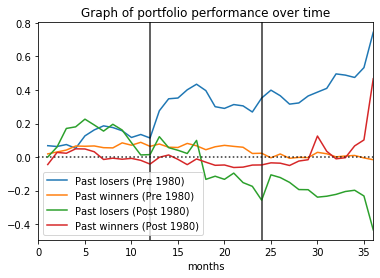

In [12]:
#Comparing pre 1980 and post 1980

#Adding plotting and t-test for pre- and post-1980
def pre_post_1980_portfolios(date,df,form_period,n_stocks,benchmark, weighting, hold_per):
    portfolios = {}
    for date in dates:
        portfolios[date] = compute_performance_portfolios(date, df_crsp,form_period,n_stocks,benchmark)
    date = dates[0]
    portfolio = portfolios[date][0] # Bottom portfolio.
    bottom_portfolio_ret = []
    top_portfolio_ret = []

    for date in dates:
        bottom_portfolio_ret.append(compute_holding_returns(date, portfolios[date][0], df_crsp, benchmark, weighting,hold_per))
        top_portfolio_ret.append(compute_holding_returns(date, portfolios[date][1], df_crsp, benchmark, weighting,hold_per))
    bottom_portfolio_ret = pd.concat(bottom_portfolio_ret)
    top_portfolio_ret = pd.concat(top_portfolio_ret)    
    # Only pre 1980
    ax1 = bottom_portfolio_ret.set_index('date')[:'1980'].groupby('months')['exret'].mean().plot(label='Past losers (Pre 1980)')
    top_portfolio_ret.set_index('date')[:'1980'].groupby('months')['exret'].mean().plot(ax=ax1, label='Past winners (Pre 1980)')
    ax1.legend()
    ax1.axhline(y=0,  color='black', alpha=0.5, linestyle=':')
    ax1.axvline(x=12, color='black', alpha=0.5, linestyle='-')
    ax1.axvline(x=24, color='black', alpha=0.5, linestyle='-')
    ax1 = bottom_portfolio_ret.set_index('date')['1980':].groupby('months')['exret'].mean().plot(label='Past losers (Post 1980)')
    top_portfolio_ret.set_index('date')['1980':].groupby('months')['exret'].mean().plot(ax=ax1, label='Past winners (Post 1980)')
    ax1.legend()
    ax1.axhline(y=0,  color='black', alpha=0.5, linestyle=':')
    ax1.axvline(x=12, color='black', alpha=0.5, linestyle='-')
    ax1.axvline(x=24, color='black', alpha=0.5, linestyle='-')
    ax1.set_title(label = 'Graph of portfolio performance over time')
    
    tset, pval = stats.ttest_ind(top_portfolio_ret[top_portfolio_ret['months']==hold_per].set_index('date')[:'1980']['exret'],
                                 bottom_portfolio_ret[top_portfolio_ret['months']==hold_per].set_index('date')[:'1980']['exret'])
    print('Mean Excess Return for Top Performing Funds Pre-1980 ' + str(top_portfolio_ret[top_portfolio_ret['months']==hold_per].set_index('date')[:'1980']['exret'].mean()))
    print('Mean Excess Return for Bottom Performing Funds Pre-1980 ' + str(bottom_portfolio_ret[top_portfolio_ret['months']==hold_per].set_index('date')[:'1980']['exret'].mean()))
    print('Mean Difference Bottom Minus Top in Excess Return ' + 
            str(bottom_portfolio_ret[top_portfolio_ret['months']==hold_per].set_index('date')[:'1980']['exret'].mean() - 
                top_portfolio_ret[top_portfolio_ret['months']==hold_per].set_index('date')[:'1980']['exret'].mean()))
    print('P-values ' + str(pval))
    if pval < 0.05:    # alpha value is 0.05 or 5%
        print(" we are rejecting null hypothesis")
    else:
        print("we are accepting null hypothesis")
            
    tset, pval = stats.ttest_ind(top_portfolio_ret[top_portfolio_ret['months']==hold_per].set_index('date')['1980':]['exret'],
                                 bottom_portfolio_ret[top_portfolio_ret['months']==hold_per].set_index('date')['1980':]['exret'])
    print('\n\nMean Excess Return for Top Performing Funds Post-1980 ' + 
          str(top_portfolio_ret[top_portfolio_ret['months']==hold_per].set_index('date')['1980':]['exret'].mean()))
    print('Mean Excess Return for Bottom Performing Funds Post-1980 ' + 
          str(bottom_portfolio_ret[top_portfolio_ret['months']==hold_per].set_index('date')['1980':]['exret'].mean()))
    print('Mean Difference Bottom Minus Top in Excess Return ' + 
            str(bottom_portfolio_ret[top_portfolio_ret['months']==hold_per].set_index('date')['1980':]['exret'].mean() - 
                top_portfolio_ret[top_portfolio_ret['months']==hold_per].set_index('date')['1980':]['exret'].mean()))
    print('P-values ' + str(pval))
    if pval < 0.05:    # alpha value is 0.05 or 5%
        print(" we are rejecting null hypothesis")
    else:
        print("we are accepting null hypothesis")
    
pre_post_1980_portfolios(date,df=df_crsp,form_period=36,n_stocks=35,benchmark='vwretd',weighting='vw',hold_per=36)

The buy losers sell winners strategy is no longer viable post-1980 and the mean difference in excess returns between bottom performing portfolios minus top performing portfolios is negative. In fact, the mean excess return for top performing funds post-1980 is positive while the mean excess return of bottome performing funds are negative. 

When performing a t-test on the difference of excess returns between bottom and top performing funds post-1980, the null hypothesis is not rejected and there is no statistically significant difference between the performance of top and bottom funds.

## Picking 50 ETFs to test whether overreaction hypothesis holds in the recent years. 

In [13]:
#Q5.
#input cleaned csv file
df_q5 = pd.read_csv('final.csv',parse_dates=True)
df_q5['Date']=pd.to_datetime(df_q5['Date'])
df_q5 = df_q5.dropna()

In [14]:
df_q5 = df_q5.set_index('Date')
df_q5 = df_q5.sort_index()
df_q5.head()
#ETF is similar to 'permno'
#Close is the closing price and 'prc'
#retetf is the return on the etf
#rets_p is returns on benchmark s&p500 on that date

,ETF,Open,High,Low,Close,Volume,OpenInt,retetf,rets_p
Date,,,,,,,,,
2005-01-02,qqq,33.860,34.005,33.752,33.888,84821384,0,0.003375,0.006891
2005-01-03,efa,45.150,45.325,45.111,45.257,2725634,0,0.005488,0.005658
2005-01-03,fxi,16.470,16.470,16.317,16.342,1060858,0,-0.004750,0.005658
2005-01-03,ezu,30.879,31.004,30.788,30.973,103776,0,0.004117,0.005658
2005-01-03,vnq,40.079,40.577,40.079,40.577,45622,0,0.010484,0.005658


In [15]:
ETF_count = df_q5.groupby('ETF')['ETF'].count()
print('There are ' + str(len(ETF_count)) + ' ETFs in this dataframe')
ETF_count

There are 51 ETFs in this dataframe


ETF
agg    3201
dia    3201
eem    3201
efa    3201
ewa    3201
ewc    3201
ewg    3201
ewh    3201
ewj    3201
ews    3201
ewt    3201
eww    3201
ewy    3201
ewz    3201
ezu    3201
fxi    3201
ibb    3201
ief    3201
ijh    3201
ijr    3201
ilf    3201
ivv    3201
iwb    3201
iwd    3201
iwf    3201
iwm    3201
iwn    3201
iwo    3201
iyr    3201
lqd    3201
mdy    3201
oef    3201
oih    3201
qqq    3225
shy    3201
smh    3201
spy    3201
tlt    3201
vgk    3192
vnq    3201
vti    3201
vwo    3192
xlb    3201
xle    3201
xlf    3201
xli    3201
xlk    3201
xlp    3201
xlu    3201
xlv    3201
xly    3201
Name: ETF, dtype: int64

In [16]:
cols = df_q5.columns
print(cols)
print(type(cols))

# List comprehension [expression for variable in iterable]
df_q5.columns = [c.lower() for c in cols]

#log returns
df_q5['lret'] = np.log(1 + df_q5['retetf'])
df_q5['lrets_p'] = np.log(1 + df_q5['rets_p'])

df_q5.tail()

Index(['ETF', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt', 'retetf',
       'rets_p'],
      dtype='object')
<class 'pandas.core.indexes.base.Index'>


,etf,open,high,low,close,volume,openint,retetf,rets_p,lret,lrets_p
Date,,,,,,,,,,,
2017-12-10,smh,96.83,97.14,96.47,96.53,2900424,0,-0.002068,-0.001687,-0.002070,-0.001688
2017-12-10,dia,228.31,228.63,227.97,228.15,1301721,0,-0.001226,-0.001687,-0.001227,-0.001688
2017-12-10,ewy,72.23,72.37,72.15,72.21,2579991,0,0.005991,-0.001687,0.005973,-0.001688
2017-12-10,vgk,58.72,58.89,58.65,58.79,1811986,0,-0.001359,-0.001687,-0.001360,-0.001688
2017-12-10,tlt,124.29,124.72,123.98,124.69,7156401,0,0.004269,-0.001687,0.004260,-0.001688


In [17]:
# Parameters
form_period = 12 # Formation period, in months
start_date = '2008-01-01' 
end_date = '2017-01-01' 
dates = pd.date_range(start=start_date, end=end_date, freq=str(np.int(form_period)) + 'M')

n_stocks = 25  
benchmark = 'rets_p' # Benchmark S&P 500 

dates

DatetimeIndex(['2008-01-31', '2009-01-31', '2010-01-31', '2011-01-31',
               '2012-01-31', '2013-01-31', '2014-01-31', '2015-01-31',
               '2016-01-31'],
              dtype='datetime64[ns]', freq='12M')

In [18]:
# Let's first do it for only one date.
date = dates[0]
print(dates[0])

beg_dt = date - pd.offsets.MonthEnd(1) * form_period
print(beg_dt)

# Select obs for the formation period
crsp_t_q5 = df_q5[beg_dt:date].copy()

2008-01-31 00:00:00
2007-01-31 00:00:00


In [19]:
crsp_t_q5.head()

,etf,open,high,low,close,volume,openint,retetf,rets_p,lret,lrets_p
Date,,,,,,,,,,,
2007-01-31,ivv,124.440,125.740,124.260,125.410,1277606,0,0.006743,0.006593,0.006721,0.006571
2007-01-31,fxi,29.421,29.823,29.071,29.489,13788328,0,-0.027279,0.006593,-0.027658,0.006571
2007-01-31,qqq,39.614,40.166,39.384,40.059,173570888,0,0.009933,0.006593,0.009884,0.006571
2007-01-31,vnq,63.649,64.214,63.236,64.076,182741,0,0.007912,0.006593,0.007881,0.006571
2007-01-31,iyr,69.549,70.349,69.279,70.333,4379287,0,0.011389,0.006593,0.011325,0.006571


In [20]:
#we have to adjust some values in the function
def compute_performance_portfolios_q5(date, df, form_period=12, n_stocks=10,
                                   benchmark='rets_p'):
    beg_dt = date - pd.offsets.MonthEnd(1) * form_period

    # Select obs for the formation period
    crsp_t_q5 = df[beg_dt:date].copy()
    
    # We only want to keep stocks that are there during the full formation window
    crsp_t_q5['N'] = crsp_t_q5.groupby(['etf'])['etf'].transform('count')
    # Filter on number of observations. We only keep stocks for which we have returns
    # over the full observation period.
    crsp_t_q5 = crsp_t_q5[crsp_t_q5['N'] >= form_period]
    
    # Now for each stock we want to compute the full period return. Easy with log returns, just sum up!
    stock_ret = crsp_t_q5.groupby('etf')[['lret', 'lrets_p']].sum()
    
    # Next compute excess returns based on the chosen index.
    # Note that since the benchmark is the same for all stocks, we could use
    # actual returns for ranking purposes.
    stock_ret['lexret'] = stock_ret['lret'] - stock_ret['l' + benchmark]
    
    # Now rankings.
    stock_ret['rank_asc'] = stock_ret['lexret'].rank() # (1 = worst return)
    stock_ret['rank_inv'] = stock_ret['lexret'].rank(ascending=False) # (1= best return)
    
    # Assign stock to top or bottom portfolio
    top_portfolio = stock_ret[stock_ret.rank_inv <= n_stocks].reset_index()[['etf', 'lexret']]
    bottom_portfolio = stock_ret[stock_ret.rank_asc <= n_stocks].reset_index()[['etf', 'lexret']]
    
    return (bottom_portfolio, top_portfolio)

In [21]:
portfolios = {}
for date in dates:
    portfolios[date] = compute_performance_portfolios_q5(date, df_q5, benchmark='rets_p')

In [22]:
# Losing ETFs
portfolios[date][0]

,etf,lexret
0,eem,-0.147621
1,ewc,-0.175230
2,ews,-0.223383
3,ewt,-0.144249
4,ewz,-0.485921
5,fxi,-0.134217
6,ilf,-0.324509
7,oih,-0.262485
8,vwo,-0.152293
9,xle,-0.228441


In [23]:
# Winning ETFs
portfolios[date][1]

,etf,lexret
0,dia,0.020026
1,ibb,0.058302
2,ivv,0.020872
3,iwf,0.039860
4,oef,0.042748
5,qqq,0.079290
6,xlk,0.070419
7,xlp,0.081079
8,xlv,0.041138
9,xly,0.085694


In [24]:
date = dates[0]
portfolio = portfolios[date][0] # Bottom portfolio.

hold_period = 12 # Holding period
benchmark = 'rets_p' # 
weighting = 'ew' # 'vw' or 'ew'

portfolio = portfolio.copy()
end_dt = date + pd.offsets.MonthEnd(1) * hold_period

# Select obs for the formation period
crsp_t2_q5 = df_q5[date:end_dt].copy()

In [25]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
etf       10 non-null object
lexret    10 non-null float64
dtypes: float64(1), object(1)
memory usage: 288.0+ bytes


In [26]:
crsp_t2_q5

,etf,open,high,low,close,volume,openint,retetf,rets_p,lret,lrets_p
Date,,,,,,,,,,,
2008-01-31,fxi,38.8370,41.4450,38.6580,40.9150,38599165,0,0.011996,0.016772,0.011925,0.016633
2008-01-31,ewz,61.1210,64.2370,60.7160,64.0410,21695253,0,0.025329,0.016772,0.025013,0.016633
2008-01-31,xlb,34.0570,35.0050,33.5190,34.6720,15336161,0,0.017789,0.016772,0.017633,0.016633
2008-01-31,ewj,45.6300,46.6550,45.5210,46.3570,8653583,0,0.013578,0.016772,0.013487,0.016633
2008-01-31,xlu,30.2540,31.1410,29.8410,30.5720,5695425,0,0.013157,0.016772,0.013071,0.016633
...,...,...,...,...,...,...,...,...,...,...,...
2009-01-30,xlf,6.9548,7.0198,6.5578,6.6733,318014887,0,-0.027372,-0.022789,-0.027753,-0.023053
2009-01-30,xli,18.3600,18.4520,17.7330,17.9150,9076844,0,-0.021306,-0.022789,-0.021536,-0.023053
2009-01-30,ewy,24.9790,25.1830,24.3000,24.6170,10882616,0,-0.008219,-0.022789,-0.008253,-0.023053


In [27]:
def compute_holding_returns_q5(date, portfolio, df, benchmark='rets_p', weighting='ew', hold_period=12):
    portfolio = portfolio.copy()
    end_dt = date + pd.offsets.MonthEnd(1) * hold_period
    # Select obs for the formation period
    crsp_t2_q5 = df[date:end_dt].copy()
    # Merge with stocks in portfolios, to keep only those stocks
    crsp_t2_q5 = pd.merge(crsp_t2_q5.reset_index(), portfolio, on=['etf'])
    crsp_t2_q5
    

    # Get the dates in the dataset.
    pairs_t2 = [{'Date': d, 'etf': p} for d in crsp_t2_q5['Date'].unique() for p in portfolio['etf'].unique()]
    pairs_t2 = pd.DataFrame(pairs_t2)
    pairs_t2
    crsp_t2_q5 = pd.merge(crsp_t2_q5, pairs_t2, how='outer', on=['etf', 'Date'])
    ret_cols = ['retetf', 'rets_p', 'lret', 'lrets_p', 'lexret']
    crsp_t2_q5[ret_cols] = crsp_t2_q5[ret_cols].fillna(0.0)
    
    # Now we want the return up to each point in time
    crsp_t2_q5['lcumret'] = crsp_t2_q5.groupby('etf')['lret'].cumsum()
    crsp_t2_q5['lcum' + benchmark] = crsp_t2_q5.groupby('etf')['l' + benchmark].cumsum()

    # At each point in time, the return of the portfolio will be the 
    # cumulative return of each component weighted by the initial weight.
    # Note that here we need the simple return average, not log return.
    crsp_t2_q5['cumret'] = np.exp(crsp_t2_q5['lcumret']) - 1
    crsp_t2_q5['cum' + benchmark] = np.exp(crsp_t2_q5['lcum' + benchmark]) - 1

    # Add weights, equal weighted is easy.
    portfolio['ew'] = 1 / len(portfolio)
    
    # Now merge back with returns
    crsp_t2_q5 = pd.merge(crsp_t2_q5, portfolio, on='etf')
    
    # Now compute the weighted cumulative return
    crsp_t2_q5['wcumret'] = crsp_t2_q5[weighting] * crsp_t2_q5['cumret']
    crsp_t2_q5['wcum' + benchmark] = crsp_t2_q5[weighting] * crsp_t2_q5['cum' + benchmark]

    portfolio_ret = crsp_t2_q5.groupby(['Date'])[['wcumret', 'wcum' + benchmark]].sum()
    
    # Count the months
    portfolio_ret = portfolio_ret.reset_index()
    portfolio_ret['days'] = portfolio_ret.index.values + 1
    
    portfolio_ret['exret'] = portfolio_ret['wcumret'] - portfolio_ret['wcum' + benchmark]
    
    return portfolio_ret

In [28]:
bottom_portfolio_ret_q5 = []
top_portfolio_ret_q5 = []

for date in dates:
    bottom_portfolio_ret_q5.append(compute_holding_returns_q5(date, portfolios[date][0], df_q5, benchmark='rets_p',hold_period=12))
    top_portfolio_ret_q5.append(compute_holding_returns_q5(date, portfolios[date][1], df_q5, benchmark='rets_p',hold_period=12))

In [29]:
bottom_portfolio_ret_q5 = pd.concat(bottom_portfolio_ret_q5)
top_portfolio_ret_q5 = pd.concat(top_portfolio_ret_q5)

In [30]:
bottom_portfolio_ret_q5

,Date,wcumret,wcumrets_p,days,exret
0,2008-01-31,0.024690,0.016772,1,0.007918
1,2008-02-01,0.014458,0.002092,2,0.012366
2,2008-02-04,0.014995,0.000154,3,0.014841
3,2008-02-05,0.016768,0.003390,4,0.013378
4,2008-02-06,0.007117,-0.007150,5,0.014266
...,...,...,...,...,...
245,2017-01-25,0.252274,0.117142,246,0.135132
246,2017-01-26,0.245480,0.116320,247,0.129159
247,2017-01-27,0.243319,0.115353,248,0.127966
248,2017-01-30,0.229218,0.108650,249,0.120567


In [31]:
top_portfolio_ret_q5

,Date,wcumret,wcumrets_p,days,exret
0,2008-01-31,0.020284,0.016772,1,0.003512
1,2008-02-01,0.011182,0.002092,2,0.009090
2,2008-02-04,0.013540,0.000154,3,0.013386
3,2008-02-05,0.024846,0.003390,4,0.021456
4,2008-02-06,0.016117,-0.007150,5,0.023266
...,...,...,...,...,...
245,2017-01-25,0.072658,0.117142,246,-0.044484
246,2017-01-26,0.071090,0.116320,247,-0.045230
247,2017-01-27,0.072076,0.115353,248,-0.043277
248,2017-01-30,0.065860,0.108650,249,-0.042791


Mean Excess Return for Top Performing Funds -0.033735392471217145
Mean Excess Return for Bottom Performing Funds -0.01301728649298225
Mean Difference Bottom Minus Top in Excess Return 0.020718105978234896
P-values 0.7287351823352595
we are accepting null hypothesis


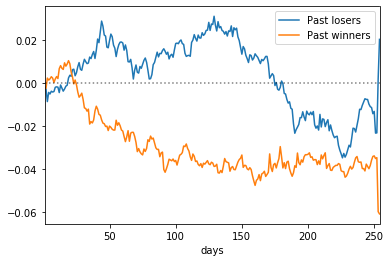

In [32]:
ax = bottom_portfolio_ret_q5.groupby('days')['exret'].mean().plot(label='Past losers')
top_portfolio_ret_q5.groupby('days')['exret'].mean().plot(ax=ax, label='Past winners')
ax.legend()
ax.axhline(y=0,  color='black', alpha=0.5, linestyle=':')

    #run a univariate t-test to ask the question if the average return for the winning portfolio is statistically different from zero

tset, pval = stats.ttest_ind(top_portfolio_ret_q5[top_portfolio_ret_q5['days']==250].set_index('Date')['exret'],
                             bottom_portfolio_ret_q5[top_portfolio_ret_q5['days']==250].set_index('Date')['exret'])

print('Mean Excess Return for Top Performing Funds ' + str(top_portfolio_ret_q5[top_portfolio_ret_q5['days']==250].set_index('Date')['exret'].mean()))
print('Mean Excess Return for Bottom Performing Funds ' + str(bottom_portfolio_ret_q5[top_portfolio_ret_q5['days']==250].set_index('Date')['exret'].mean()))
print('Mean Difference Bottom Minus Top in Excess Return ' + 
      str(bottom_portfolio_ret_q5[top_portfolio_ret_q5['days']==250].set_index('Date')['exret'].mean() -                                                        
          top_portfolio_ret_q5[top_portfolio_ret_q5['days']==250].set_index('Date')['exret'].mean()))
print('P-values ' + str(pval))
if pval < 0.05:    # alpha value is 0.05 or 5%
    print(" we are rejecting null hypothesis")
else:
    print("we are accepting null hypothesis")

Mean Excess Return for Top Performing Funds -0.0014807355018311233
Mean Excess Return for Bottom Performing Funds -0.07094801608651614
Mean Difference Bottom Minus Top in Excess Return -0.06946728058468501
P-values 0.17457084577646587
we are accepting null hypothesis


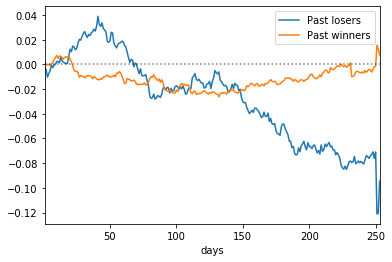

In [33]:
#Look at chart past 2012 for more recency
ax = bottom_portfolio_ret_q5.set_index('Date')['2012':].groupby('days')['exret'].mean().plot(label='Past losers')
top_portfolio_ret_q5.set_index('Date')['2012':].groupby('days')['exret'].mean().plot(ax=ax, label='Past winners')
ax.legend()
ax.axhline(y=0,  color='black', alpha=0.5, linestyle=':')
    
#run a univariate t-test to ask the question if the average return for the winning portfolio is statistically different from zero

tset, pval = stats.ttest_ind(top_portfolio_ret_q5[top_portfolio_ret_q5['days']==250].set_index('Date')['2012':]['exret'],
                             bottom_portfolio_ret_q5[top_portfolio_ret_q5['days']==250].set_index('Date')['2012':]['exret'])

print('Mean Excess Return for Top Performing Funds ' + str(top_portfolio_ret_q5[top_portfolio_ret_q5['days']==250].set_index('Date')['2012':]['exret'].mean()))
print('Mean Excess Return for Bottom Performing Funds ' + str(bottom_portfolio_ret_q5[top_portfolio_ret_q5['days']==250].set_index('Date')['2012':]['exret'].mean()))
print('Mean Difference Bottom Minus Top in Excess Return ' + 
      str(bottom_portfolio_ret_q5[top_portfolio_ret_q5['days']==250].set_index('Date')['2012':]['exret'].mean() -                                                        
          top_portfolio_ret_q5[top_portfolio_ret_q5['days']==250].set_index('Date')['2012':]['exret'].mean()))
print('P-values ' + str(pval))
if pval < 0.05:    # alpha value is 0.05 or 5%
    print(" we are rejecting null hypothesis")
else:
    print("we are accepting null hypothesis")